# Chest X-Ray

At first try to import all necessary packages for our project. 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator

In [5]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

The dataset is too larget to compute the very small machine of us. So we take only 1400 images. For,

#### training - 875 images

#### validation - 109 images

#### testing 420 images

In [6]:
# Load the csv files

train_df = pd.read_csv("/content/gdrive/MyDrive/X-ray/train-small.csv")
valid_df = pd.read_csv("/content/gdrive/MyDrive/X-ray/valid-small.csv")

test_df = pd.read_csv("/content/gdrive/MyDrive/X-ray/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [7]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

In [9]:
# Check is there any missing values
train_df.isnull().sum()

Image                 0
Atelectasis           0
Cardiomegaly          0
Consolidation         0
Edema                 0
Effusion              0
Emphysema             0
Fibrosis              0
Hernia                0
Infiltration          0
Mass                  0
Nodule                0
PatientId             0
Pleural_Thickening    0
Pneumonia             0
Pneumothorax          0
dtype: int64

## Prevent Data Leakage

It is important to check wheathe a patient have multiple data or not. It can be happen, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

#### Unique ID check

In [10]:
print(f"The total patiend ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")

The total patiend ids are 1000, from those the unique ids are 928 


As it is clear, the number of unique patients in the dataset is less than the total number so there must be some overlap. For patients with multiple records, we want to make sure they do not show up in both training and test sets in order to avoid data leakage. 


Now write a function to check wheather there is a leakage between two dataset

In [11]:
def dataset_leakage(df1, df2, patient_col):
    
    df1_patient_unique = set(df1[patient_col])
    df2_patient_unique = set(df2[patient_col])
    
    patient_in_both_grp = df1_patient_unique.intersection(df2_patient_unique)
    
    if patient_in_both_grp:
        leakage = True
    else:
        leakage = False
    
    return leakage

In [12]:
# test
print("test case 1")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 3, 4]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {dataset_leakage(df1, df2, 'patient_id')}")
print("-------------------------------------")

print("test case 2")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 5, 10]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {dataset_leakage(df1, df2, 'patient_id')}")

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True
-------------------------------------
test case 2
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           5
2          10
leakage output: True


In [13]:
print("leakage between train and test: {}".format(dataset_leakage(train_df, test_df, 'PatientId')))
print("leakage between train and test: {}".format(dataset_leakage(train_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between train and test: False


## Data Visualization

In [14]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [15]:
# Remove unnecesary elements
columns.remove('Image')
columns.remove('PatientId')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [16]:
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


Display Random images


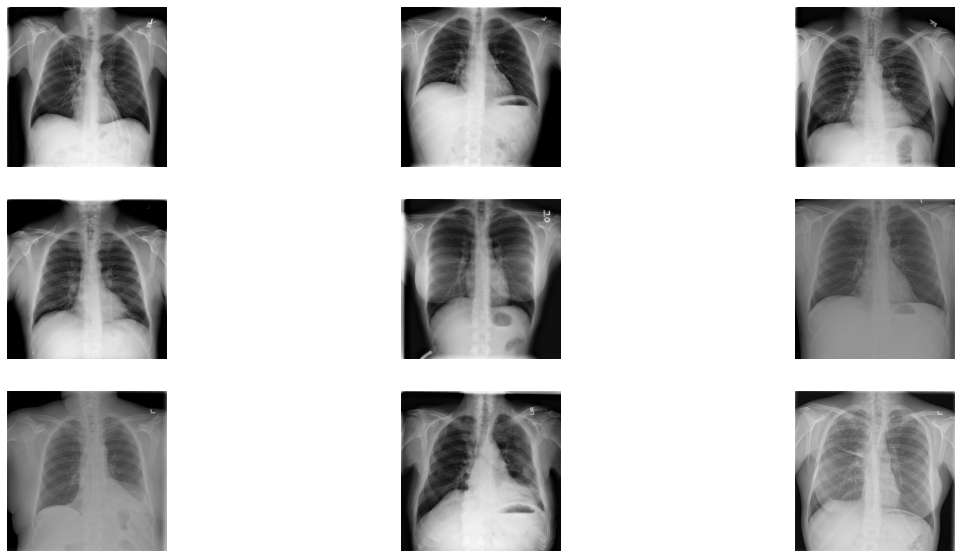

In [17]:
images = train_df['Image'].values

random_image = [np.random.choice(images) for i in range(9)] 

img_dir = '/content/gdrive/MyDrive/X-ray/images-small/'
print("Display Random images")

plt.figure(figsize = (20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_image[i]))
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    
#plt.tight_layout() 

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


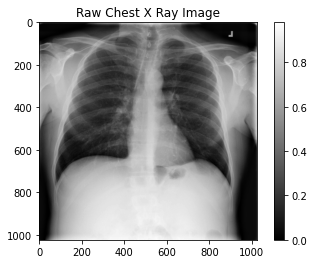

In [18]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Pixel value Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

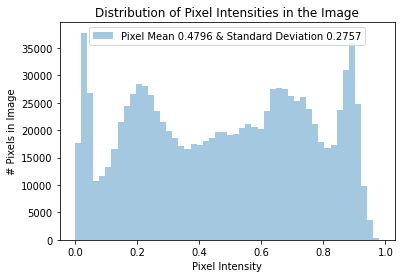

In [19]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

## Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

In [20]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
          
    print("getting train generator...") 
    
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    
    generator = image_generator.flow_from_dataframe(
                dataframe = df,
                directory = image_dir,
                x_col = x_col,
                y_col = y_col,
                class_mode = "raw",
                batch_size = batch_size,
                shuffle = shuffle,
                seed = seed,
                target_size = (target_w, target_h))
    
    return generator

Build a separate generator for valid and test sets
Now we need to build a new generator for validation and testing data.

#### Why can't we use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning that it uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage.
The model should not have any information about the test data.
What we need to do is normalize incoming test data using the statistics computed from the training set.

We implement this in the function below.
There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set.
However, since this is extremely large, that would be very time consuming.
In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [21]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe = train_df, 
        directory = IMAGE_DIR, 
        x_col = "Image", 
        y_col = labels, 
        class_mode = "raw", 
        batch_size = sample_size, 
        shuffle = True, 
        target_size = (target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return valid_generator, test_generator

In [22]:
IMAGE_DIR = "/content/gdrive/MyDrive/X-ray/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 1 validated image filenames.
Found 420 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


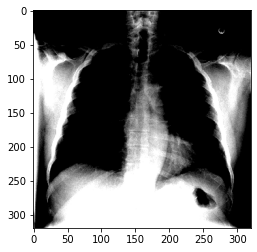

In [23]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

## Class Imbalance

To avoid having class imbalance impact the loss function is to weight the losses differently. To choose the weights, you first need to calculate the class frequencies.

For this exercise, you'll just get the count of each label. Later on, you'll use the concepts practiced here to calculate frequencies in the assignment!

In [24]:
# Count up the number of instances of each class (drop non-class columns from the counts)
class_counts = train_df.sum().drop(['Image','PatientId'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


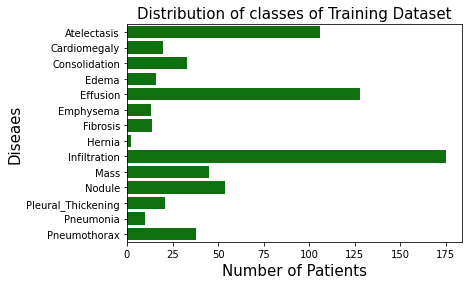

In [25]:
sns.barplot(class_counts.values, class_counts.index, color = 'g')
plt.title("Distribution of classes of Training Dataset", fontsize = 15)
plt.xlabel('Number of Patients', fontsize = 15)
plt.ylabel('Diseaes', fontsize = 15)
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.)

The Hernia pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%.
But even the Infiltration pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss.

### Computing Class Frequencies

In [26]:
def compute_class_frequencies(labels):

  N = labels.shape[0]

  positive_frequencies = np.sum(labels, axis = 0) / N
  negetive_frequencies = 1 - positive_frequencies

  return positive_frequencies, negetive_frequencies

In [27]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_frequencies(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [28]:
# Compute frequencies for training
freq_pos, freq_neg = compute_class_frequencies(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

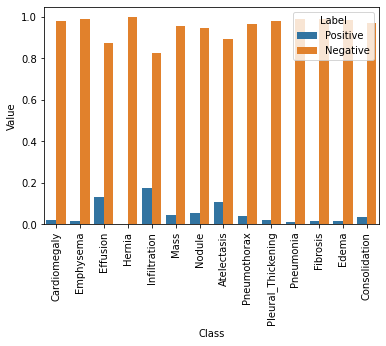

In [29]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation = 90)
f = sns.barplot(x = "Class", y = "Value", hue = "Label" ,data = data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [30]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

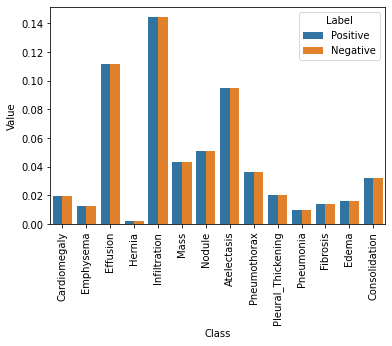

In [31]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

## Weighted Loss

In [32]:
def get_weighted_loss(pos_weights, neg_weights, epsilon = 1e-7):

  def weighted_loss(y_true, y_pred):

    loss = 0.0

    for i in range(pos_weights):

      loss += K.mean(-(pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i] * (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))
      
    return loss

  return weighted_loss

In [33]:
# Test
sess = tf.compat.v1.keras.backend.get_session()
with sess.as_default() as sess:
    print("Test example:\n")
    y_true = K.constant(np.array(
        [[1, 1, 1],
         [1, 1, 0],
         [0, 1, 0],
         [1, 0, 1]]
    ))
    print("y_true:\n")
    #print(y_true.eval())

    w_p = np.array([0.25, 0.25, 0.5])
    w_n = np.array([0.75, 0.75, 0.5])
    print("\nw_p:\n")
    print(w_p)

    print("\nw_n:\n")
    print(w_n)

    y_pred_1 = K.constant(0.7*np.ones(y_true.shape))
    print("\ny_pred_1:\n")
    #print(y_pred_1.eval())

    y_pred_2 = K.constant(0.3*np.ones(y_true.shape))
    print("\ny_pred_2:\n")
    #print(y_pred_2.eval())

    # test with a large epsilon in order to catch errors
    L = get_weighted_loss(w_p, w_n, epsilon=1)

    print("\nIf we weighted them correctly, we expect the two losses to be the same.")
    #L1 = L(y_true, y_pred_1).eval()
    #L2 = L(y_true, y_pred_2).eval()
    #print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
    #print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

Test example:

y_true:


w_p:

[0.25 0.25 0.5 ]

w_n:

[0.75 0.75 0.5 ]

y_pred_1:


y_pred_2:


If we weighted them correctly, we expect the two losses to be the same.


## DenseNet

Next, we will use a pre-trained DenseNet121 model which we can load directly from Keras and then add two layers on top of it:

A GlobalAveragePooling2D layer to get the average of the last convolution layers from DenseNet121.
A Dense layer with sigmoid activation to get the prediction logits for each of our classes.
We can set our custom loss function for the model by specifying the loss parameter in the compile() function

In [34]:
base_model = DenseNet121(weights = '/content/gdrive/MyDrive/X-ray/densenet121.pth', include_top = False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

OSError: ignored

In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()